# Fraud - 03

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from plotnine import *
import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import xarray as xr

%matplotlib inline

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
sns.set_theme(style='white')
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

pymc3     : 3.11.4
matplotlib: 3.4.3
xarray    : 0.19.0
arviz     : 0.11.2
pandas    : 1.3.2
seaborn   : 0.11.2
numpy     : 1.19.5
plotnine  : 0.8.0



## Data Generating Process 

In [3]:
n_observations = 250

true_orange_mu, true_orange_sd = 300, 100
true_green_mu, true_green_sd = 600, 200

# Fraction of each class that will be observed.
obs_pct_orange_mu, obs_pct_orange_sd = 0.10, 0.05
obs_pct_green_mu, obs_pct_green_sd = 0.40, 0.10



df = pd.DataFrame(
    dict(
        true_orange=np.random.normal(true_orange_mu, true_orange_sd, size=n_observations),
        true_green=np.random.normal(true_green_mu, true_green_sd, size=n_observations),
        pct_obs_orange=np.random.normal(obs_pct_orange_mu, obs_pct_orange_sd, size=n_observations),
        pct_obs_green=np.random.normal(obs_pct_green_mu, obs_pct_green_sd, size=n_observations),
    ),
    columns=['true_orange', 'true_green', 'pct_obs_orange', 'pct_obs_green']
)
df['total'] = df['true_orange'] + df['true_green']
df['obs_orange'] = df['true_orange'] * df['pct_obs_orange'].clip(lower=0)
df['obs_green'] = df['true_green'] * df['pct_obs_green'].clip(lower=0)

df.drop(['pct_obs_orange', 'pct_obs_green'], axis=1, inplace=True)
df = df.round()
df

,true_orange,true_green,total,obs_orange,obs_green
0,486.0,773.0,1258.0,37.0,214.0
1,314.0,752.0,1066.0,5.0,289.0
2,345.0,588.0,933.0,24.0,255.0
3,446.0,952.0,1398.0,44.0,342.0
4,176.0,499.0,675.0,24.0,161.0
...,...,...,...,...,...
245,324.0,674.0,998.0,12.0,251.0
246,353.0,640.0,993.0,41.0,217.0
247,329.0,672.0,1001.0,48.0,219.0
248,128.0,751.0,879.0,18.0,350.0


In [78]:
n_observations = 250

true_orange_mu, true_orange_sd = 300, 100
true_green_mu, true_green_sd = 600, 200

# Fraction of each class that will be observed.
obs_pct_orange_mu, obs_pct_orange_sd = 0.10, 0.05
obs_pct_green_mu, obs_pct_green_sd = 0.40, 0.10

true_orange=pm.TruncatedNormal.dist(true_orange_mu, true_orange_sd, lower=0).random(size=n_observations)
true_orange = [int(x) for x in true_orange]
true_green=pm.TruncatedNormal.dist(true_green_mu, true_green_sd, lower=0).random(size=n_observations)
true_green = [int(x) for x in true_green]
pct_obs_orange=pm.TruncatedNormal.dist(obs_pct_orange_mu, obs_pct_orange_sd, lower=0).random(size=n_observations)
pct_obs_green=pm.TruncatedNormal.dist(obs_pct_green_mu, obs_pct_green_sd, lower=0).random(size=n_observations)

df = pd.DataFrame({'day': range(n_observations), 'true_orange': true_orange, 'true_green': true_green, 'pct_obs_orange': pct_obs_orange, 'pct_obs_green':pct_obs_green})

df['total'] = df['true_orange'] + df['true_green']
df['obs_orange'] = (df['true_orange'] * df['pct_obs_orange']).astype(int)
df['obs_green'] = (df['true_green'] * df['pct_obs_green']).astype(int)
df['obs_greenorange'] = df['obs_green'] + df['obs_orange']

# df.drop(['pct_obs_orange', 'pct_obs_green'], axis=1, inplace=True)
# df = df.round()
df

,day,true_orange,true_green,pct_obs_orange,pct_obs_green,total,obs_orange,obs_green,obs_greenorange
0,0,397,268,0.046190,0.346060,665,18,92,110
1,1,366,728,0.071295,0.468681,1094,26,341,367
2,2,170,348,0.110209,0.305873,518,18,106,124
3,3,221,433,0.057440,0.333492,654,12,144,156
4,4,405,960,0.094095,0.347237,1365,38,333,371
...,...,...,...,...,...,...,...,...,...
245,245,301,935,0.076697,0.235661,1236,23,220,243
246,246,193,745,0.108855,0.367637,938,21,273,294
247,247,298,529,0.052404,0.363513,827,15,192,207
248,248,263,527,0.081792,0.311900,790,21,164,185


In [79]:
df.describe()

,day,true_orange,true_green,pct_obs_orange,pct_obs_green,total,obs_orange,obs_green,obs_greenorange
count,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,287.72800,605.736000,0.103674,0.409380,893.464000,29.108000,247.892000,277.000000
std,72.312977,96.09524,213.754359,0.047296,0.103797,229.844388,16.698133,108.052012,109.198688
min,0.000000,49.00000,16.000000,0.011009,0.043529,280.000000,2.000000,0.000000,42.000000
25%,62.250000,224.25000,473.500000,0.070983,0.338584,738.000000,17.250000,181.500000,207.000000
50%,124.500000,283.50000,632.000000,0.102312,0.409419,910.500000,27.000000,235.000000,269.000000
75%,186.750000,348.25000,750.750000,0.131303,0.477481,1067.750000,39.000000,308.500000,340.750000
max,249.000000,542.00000,1123.000000,0.257396,0.690393,1365.000000,96.000000,532.000000,581.000000


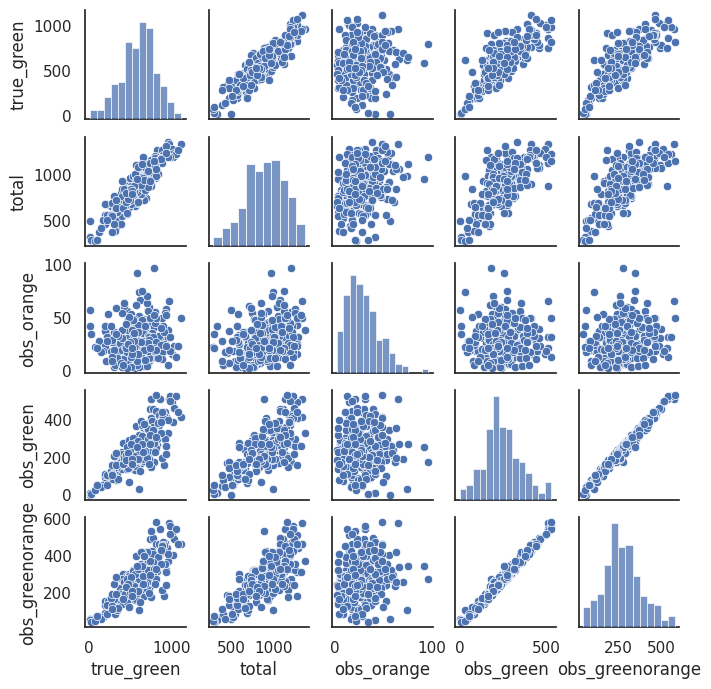

In [85]:
sns.pairplot(df[['true_green', 'total', 'obs_orange', 'obs_green', 'obs_greenorange']], height=1.4);

In [ ]:
sns.pairplot(df[['true_green', 'total', 'obs_orange', 'obs_green', 'obs_greenorange']], height=1.4);

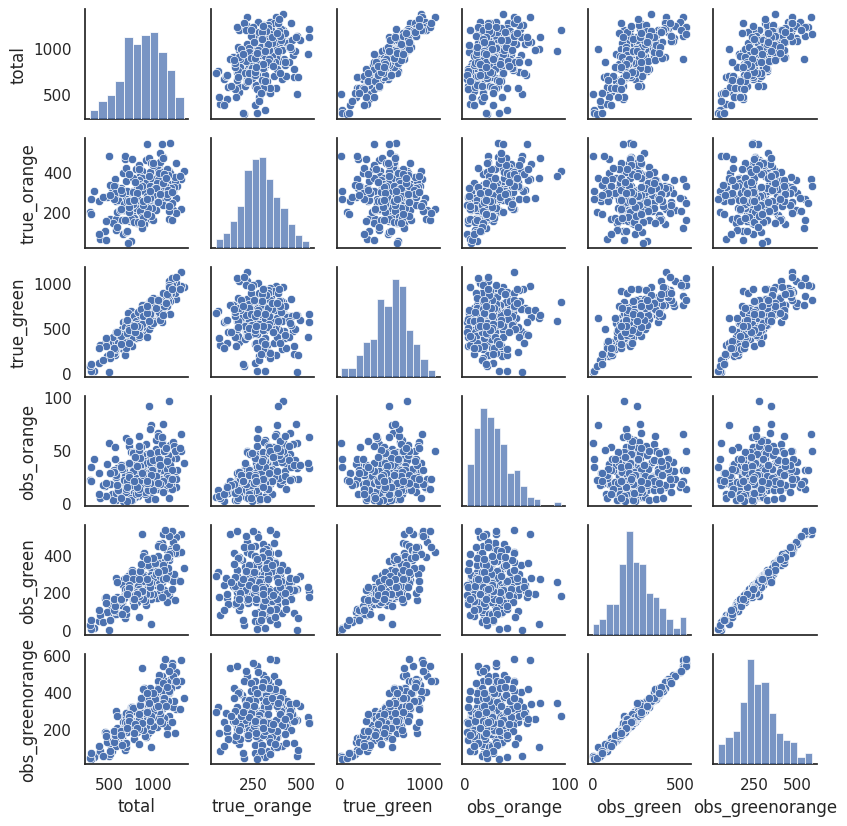

In [82]:
sns.pairplot(df[['total', 'true_orange', 'true_green', 'obs_orange', 'obs_green', 'obs_greenorange', 'pct_obs_orange']], height=1.4);

Day 0 Counts
day                  0.000000
true_orange        217.000000
true_green         892.000000
pct_obs_orange       0.187695
pct_obs_green        0.459296
total             1109.000000
obs_orange          40.000000
obs_green          409.000000
Name: 0, dtype: float64


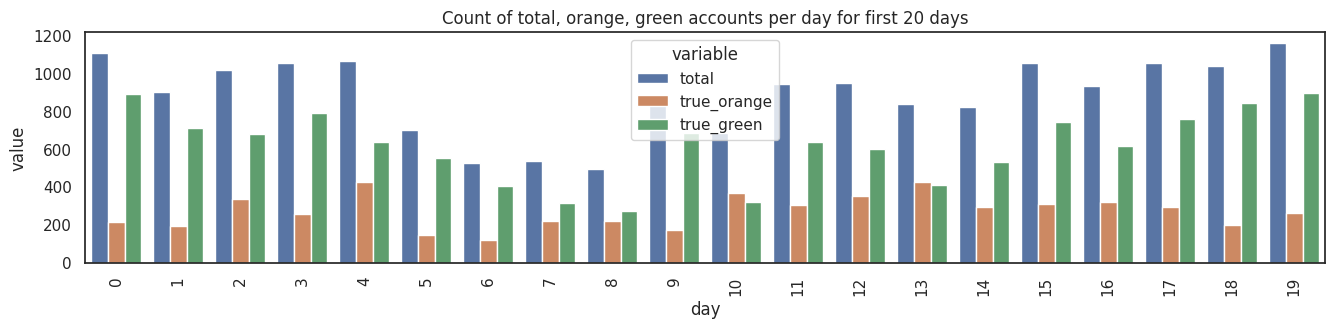

In [17]:
print(f'Day 0 Counts\n{df.loc[0]}')
fig, ax = plt.subplots(figsize=(16, 3))
data_len = 20
sns.barplot(x='day', y='value', ax=ax, hue='variable', dodge=True, data=pd.melt(df[['day', 'total', 'true_orange', 'true_green']][0:data_len], ['day']), alpha=1.0);
ax.set_title(f'Count of total, orange, green accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.show();

Day 0 Counts
day                  0.000000
true_orange        217.000000
true_green         892.000000
pct_obs_orange       0.187695
pct_obs_green        0.459296
total             1109.000000
obs_orange          40.000000
obs_green          409.000000
Name: 0, dtype: float64


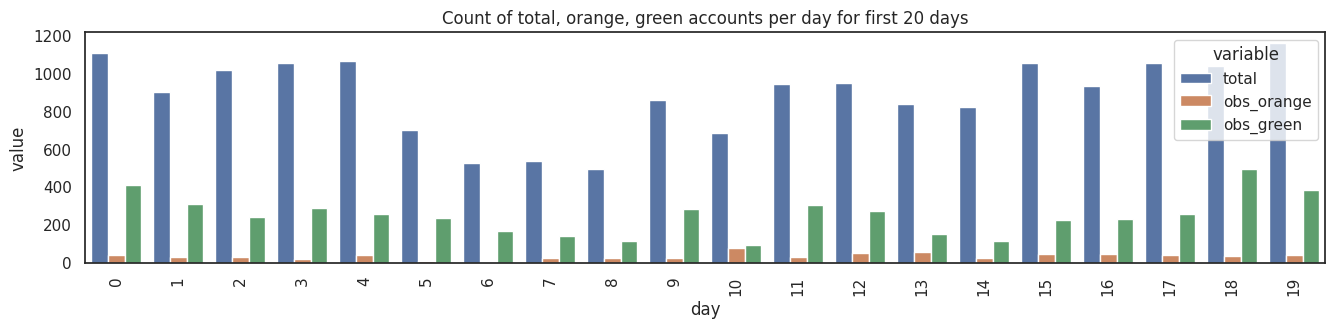

In [18]:
print(f'Day 0 Counts\n{df.loc[0]}')
fig, ax = plt.subplots(figsize=(16, 3))
data_len = 20
sns.barplot(x='day', y='value', ax=ax, hue='variable', dodge=True, data=pd.melt(df[['day', 'total', 'obs_orange', 'obs_green']][0:data_len], ['day']), alpha=1.0);
ax.set_title(f'Count of total, orange, green accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.show();

In [19]:
dfm = df.copy()
dfm = dfm[['total', 'obs_orange', 'obs_green']]
dfm

,total,obs_orange,obs_green
0,1109,40,409
1,902,33,309
2,1017,31,244
3,1052,18,288
4,1063,41,260
...,...,...,...
245,873,17,303
246,905,32,215
247,1026,42,367
248,974,31,459


In [32]:
dfm_std = dfm.copy()
dfm_std['obs_orange'] = (dfm_std['obs_orange'] - dfm_std['obs_orange'].mean()) / dfm_std['obs_orange'].std()
dfm_std['obs_green'] = (dfm_std['obs_green'] - dfm_std['obs_green'].mean()) / dfm_std['obs_green'].std()
dfm_std['total'] = (dfm_std['total'] - dfm_std['total'].mean()) / dfm_std['total'].std()
dfm_std

,total,obs_orange,obs_green
0,0.980895,0.518862,1.604243
1,-0.001538,0.123388,0.641035
2,0.544258,0.010395,0.014949
3,0.710370,-0.724057,0.438761
4,0.762576,0.575359,0.169062
...,...,...,...
245,-0.139173,-0.780553,0.583242
246,0.012700,0.066892,-0.264382
247,0.586972,0.631855,1.199696
248,0.340178,0.010395,2.085848


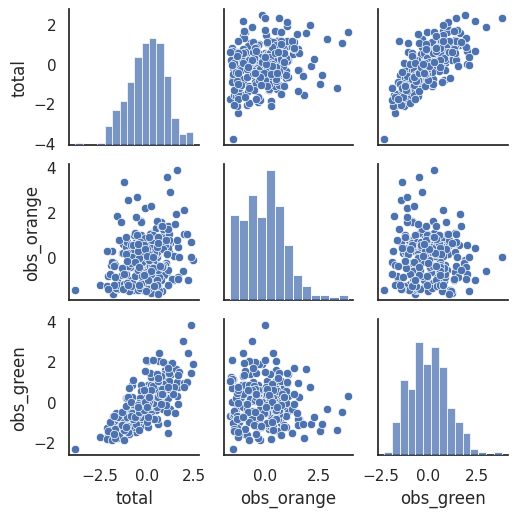

In [46]:
sns.pairplot(dfm_std[['total', 'obs_orange', 'obs_green']], height=1.75);

/tmp/ipykernel_1003595/1811319019.py:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [green_daily, sd_green, mu_green, orange_daily, sd_orange, mu_orange]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9223383956501211, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5039788789320638, but should be close to 0.8. Try to increase the number of tuning steps.
There were 317 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5788718937000498, but should be close to 0.8. Try to increase the number of tuning steps.
There were 368 divergences after tuning. Increase `target_accept` or reparameter

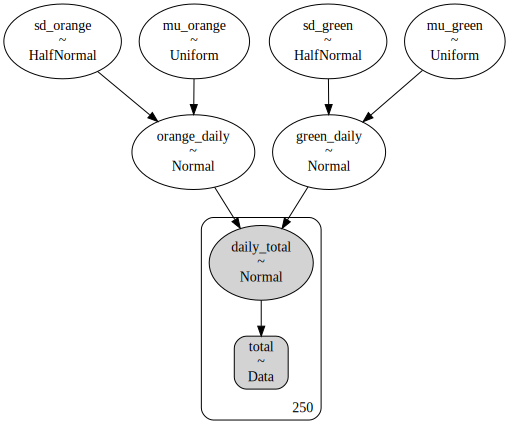

In [88]:
with pm.Model() as model1:
    # data
    obs_data_total = pm.Data("total", dfm_std['total'].values)
    
    no_upper_bounds = np.matrix(np.ones((len(dfm_std),1)) * np.inf)
    # priors
    mu_orange = pm.Uniform("mu_orange", -1, 1)
    sd_orange = pm.HalfNormal("sd_orange", 0.1)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", -1, 1)
    sd_green = pm.HalfNormal("sd_green", 0.1)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # daily_mu = pm.Deterministic('daily_mu', pm.math.clip(orange_daily + green_daily, 1, np.inf))
    # # Use observed number of orange and green to put a lower bound on modeled # of orange.
    # daily_mu_with_obs = (
    #     pm.math.clip(orange_daily, dfm_std['obs_orange'].values, np.inf)
    #     +
    #     pm.math.clip(green_daily, dfm_std['obs_green'].values, np.inf)
    # )
        
    daily_total = pm.Normal("daily_total", green_daily + orange_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=obs_data_total)
    
    
    trace = pm.sample()
    idata_model1 = az.from_pymc3(trace=trace)
pm.model_to_graphviz(model1) 

In [75]:
idata_model1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

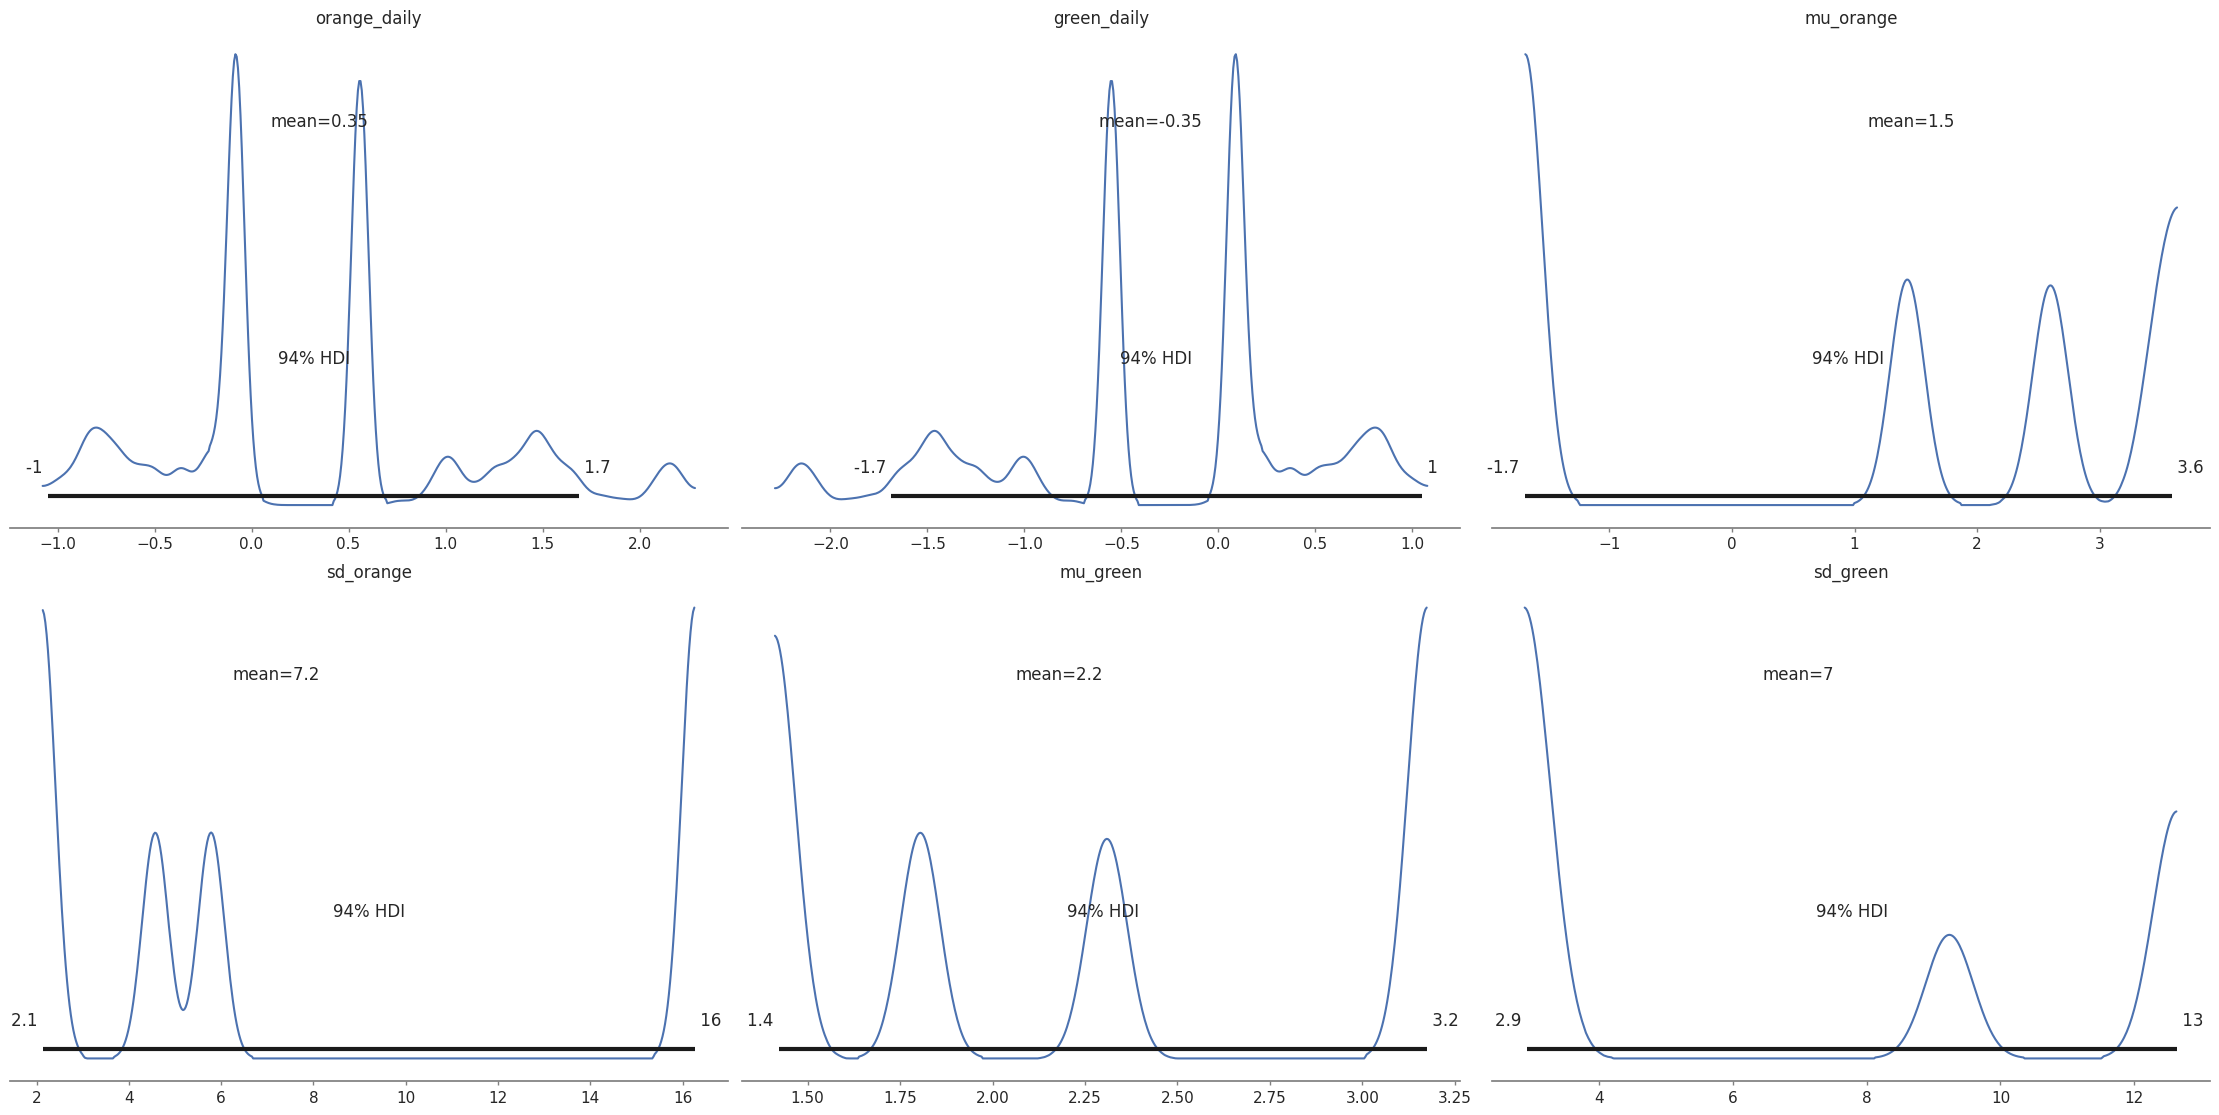

In [76]:
az.plot_posterior(idata_model1);

In [77]:
az.summary(idata_model1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
orange_daily,0.349,0.804,-1.048,1.688,0.392,0.299,4.0,11.0,3.60
green_daily,-0.349,0.804,-1.688,1.048,0.392,0.299,4.0,11.0,3.60
mu_orange,1.460,1.964,-1.690,3.587,0.978,0.749,4.0,13.0,3.86
sd_orange,7.195,5.400,2.132,16.266,2.689,2.059,4.0,12.0,3.57
mu_green,2.179,0.655,1.423,3.175,0.326,0.250,4.0,13.0,3.47
sd_green,6.977,4.140,2.926,12.639,2.062,1.578,5.0,27.0,3.33


In [71]:
dfm_std.describe()

,total,obs_orange,obs_green
count,2.500000e+02,2.500000e+02,2.500000e+02
mean,2.025047e-16,5.462297e-17,-7.105427e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.798378e+00,-1.627998e+00,-2.316016e+00
25%,-6.505601e-01,-7.805533e-01,-7.219057e-01
50%,6.016093e-02,1.039533e-02,-6.210770e-02
75%,6.510442e-01,6.318550e-01,6.193625e-01
max,2.456916e+00,3.852146e+00,3.819623e+00


In [7]:
stop

NameError: name 'stop' is not defined

In [ ]:
with pm.Model() as m10:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_10),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_10['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_10['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_10['total']
    )
    
    trace_m10 = pm.sample(1_000, chains=4, target_accept=0.9)

In [ ]:
plt.hist(pct_obs_green)

+ `n_accounts` are created per day - normally distributed `mu_accounts`, `sigma_accounts`
+ Create for `n_days` days
+ The proportion of fraudulent accounts changes on a daily basis. It is generated by selecting a proportion `p_fraudulent` from a Uniform distribution between a lower limit `p_fraudulent_min` and a higher limit `p_fraudulent_max`. The intent is to have some days with a relative low number of accounts created, but a high proportion of fraudulent accounts and vice versa. This seems somewhat realistic.
+ The daily number of fraudulent accounts = `n_accounts` x `p_fraudulent` where these values are generated for each day
+ Fraud Detection
    + The fraud detection system identifies a subset of fraudulent accounts. It never identifies a genuine account as fraudulent.
    + It works like this. If we run the detection system over multiple accounts.
        + long run frequency of detecting fraudulent | genuine = 0.0
        + long run frequency of detecting fraudulent | fraudulent = `p_detection_mean`
    + But the detection system is not perfect. It has some variation associated with it. The variation is described in terms of number of accounts. So, someone informally describing the detection system would say it detects `x` fraction of fraudulent accounts plus or minus `y` accounts. The variation is taken to be a normally distributed, centred at `p_detection`, with a standard deviation of `detection_sigma` (i.t.o number of accounts).
    + So, the 99.9 % spread of the detection system is `p_detection_mean` x `n_fraudulent` +/- 3 * `detection_sigma`

In [ ]:
# Accounts
n_days = 1000
mu_accounts = 900
sigma_accounts = 200

# Fraudulent accounts
p_fraudulent_min = 0.05
p_fraudulent_max = 0.6

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=mu_accounts, sigma=sigma_accounts, lower=0).random(size=n_days)]
p_fraudulent = pm.Uniform.dist(p_fraudulent_min, p_fraudulent_max).random(size=n_days)
n_fraudulent = [int(x) for x in n_accounts * p_fraudulent]
df = pd.DataFrame({'day': range(n_days), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent})
df['daily_p_fraudulent'] = df['n_fraudulent'] / df['n_accounts']

df

In [ ]:
print(f'Day 0 Counts\n{df.loc[0]}')
fig, ax = plt.subplots(figsize=(16, 3))
data_len = 100
sns.barplot(x='day', y='value', ax=ax, hue='variable', dodge=False, data=pd.melt(df[['day', 'n_accounts', 'n_fraudulent']][0:data_len], ['day']));
ax.set_title(f'Count of Fraudulent and total accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.show();

In [ ]:
print(f'Day 0 Counts\n{df.loc[0]}')

fig, ax = plt.subplots(figsize=(16, 3))
sns.barplot(x='day', y='daily_p_fraudulent', ax=ax, data=df[0: data_len], color='black', alpha=0.3);
ax.set_title(f'Proportion of fraudulent accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.show();

In [ ]:
p_detection_mean = 0.6
detection_sigma = 10 # accounts - if detection_sigma = 10 then the 99.9% spread of the detection system is p_detection_mean x n_fraudulent +/- 30 accounts

mean_obs_fraudulent = df['n_fraudulent'] * p_detection_mean

n_obs_fraudulent = [int(x) for x in pm.TruncatedNormal.dist(mu=mean_obs_fraudulent, sigma=detection_sigma, lower=0, upper=n_fraudulent).random(size=n_days)]
df['n_obs_fraudulent'] = n_obs_fraudulent
df['p_detection_given_fraud'] = df['n_obs_fraudulent'] / df['n_fraudulent']
df['p_detected_fraudulent'] = df['n_obs_fraudulent'] / df['n_accounts']
df 

In [ ]:
df.describe()

In [ ]:
print(f'Day 0 Counts\n{df.loc[0]}')
fig, ax = plt.subplots(figsize=(16, 3))
data_len = 100
sns.barplot(x='day', y='value', ax=ax, hue='variable', dodge=False, data=pd.melt(df[['day', 'n_accounts', 'n_fraudulent', 'n_obs_fraudulent']][0:data_len], ['day']));
ax.set_title(f'Count of Total, Fraudulent, and observed fraudulent accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.show();

In [ ]:
print(f'Day 0 Counts\n{df.loc[0]}')

fig, ax = plt.subplots(figsize=(16, 3))
sns.barplot(x='day', y='p_detection_given_fraud', ax=ax, data=df[0: data_len], color='black', alpha=0.3);
ax.set_title(f'Proportion of fradulent accounts detected as fraudulent accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.grid()
plt.show();

In [ ]:
print(f'Day 0 Counts\n{df.loc[0]}')

fig, ax = plt.subplots(figsize=(16, 3))
sns.barplot(x='day', y='p_detected_fraudulent', ax=ax, data=df[0: data_len], color='black', alpha=0.3);
ax.set_title(f'Proportion of total accounts detected as fraudulent accounts per day for first {data_len} days')
plt.xticks(rotation=90)
plt.show();

In [ ]:
df.describe()

In [ ]:
sns.pairplot(df[['n_accounts', 'n_fraudulent', 'n_obs_fraudulent']], height=1.75);

In [ ]:
sns.pairplot(df[['daily_p_fraudulent', 'p_detection_given_fraud', 'p_detected_fraudulent']], height=2.0);

### Full Forward Model

In [ ]:
def make_forward_data(n_days=1000):
    # Accounts
    # n_days = 1000 # data creation
    mu_accounts = 900 # data creation
    sigma_accounts = 200 # data creation

    # Fraudulent accounts
    p_fraudulent_min = 0.05 # data creation
    p_fraudulent_max = 0.6 # data creation

    # Detection System
    p_detection_mean = 0.6 # known estimated value
    detection_sigma = 10 # known estimated value

    n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=mu_accounts, sigma=sigma_accounts, lower=0).random(size=n_days)]
    #p_fraudulent = pm.Uniform.dist(p_fraudulent_min, p_fraudulent_max).random(size=n_days) # unknown - convert to prior in model
    p_fraudulent = pm.Uniform.dist(p_fraudulent_min, p_fraudulent_max).random() # unknown - convert to prior in model
    n_fraudulent = [int(x) for x in n_accounts * p_fraudulent] # unknown - target posterior

    df = pd.DataFrame({'day': range(n_days), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent})
    
    mean_obs_fraudulent = df['n_fraudulent'] * p_detection_mean
    n_obs_fraudulent = [int(x) for x in pm.TruncatedNormal.dist(mu=mean_obs_fraudulent, sigma=detection_sigma, lower=0, upper=n_fraudulent).random(size=n_days)] # data creation
    df['n_obs_fraudulent'] = n_obs_fraudulent
    df['p_detection_given_fraud'] = df['n_obs_fraudulent'] / df['n_fraudulent']
    df['p_detected_fraudulent'] = df['n_obs_fraudulent'] / df['n_accounts']
    
    return df

n_days = 1000
df = make_forward_data(n_days=n_days)
df

### What we see

In [ ]:
dfm = df.copy()
dfm = df[['day', 'n_accounts', 'n_obs_fraudulent']]
# What we actually see of this process
dfm.head()

### What we know/assume

In [ ]:
print(f'\nMean probability of detection: {p_detection_mean}\tDetection system stdev: {detection_sigma}\n')

# Model 1

In [ ]:
with pm.Model() as model1:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    print(n_accounts.shape[0].eval())
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    p_detection_mean_m = pm.Data('p_detection_mean', p_detection_mean)
    detection_sigma_m = pm.Data('detection_sigma', detection_sigma)
    # n_days_m = pm.Data('n_days', n_days)
    # print(n_days)
    # print(n_days_m)

    # priors
    daily_p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6, shape=n_days)
    
    # process model
    n_fraudulent = pm.Deterministic('n_fraudulent', n_accounts * daily_p_fraudulent)
    
    n_obs_fraudulentl = pm.Normal('n_obs_fraudulentl', (n_fraudulent * p_detection_mean_m), detection_sigma_m, observed=n_obs_fraudulent)
    
    prior = pm.sample_prior_predictive()
    idata_model1 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model1)

In [ ]:
idata_model1

In [ ]:
hdi_obs_fraudulentl = az.hdi(idata_model1.prior_predictive['n_obs_fraudulentl']).to_dataframe().reset_index().pivot(index='n_obs_fraudulentl_dim_0', columns='hdi').droplevel(0, axis=1).astype(int)
mean_obs_fraudulentl = idata_model1.prior_predictive['n_obs_fraudulentl'].mean(axis=1).to_dataframe().droplevel(1).reset_index(drop=True).rename(columns={'n_obs_fraudulentl': 'n_obs_fraudulentl_mean'}).astype(int)
df_prior_check = pd.concat([hdi_obs_fraudulentl, mean_obs_fraudulentl, dfm], axis=1)
df_prior_check

In [ ]:
p =(ggplot(df_prior_check[0:100], aes(x='day')) +
    geom_ribbon(aes(ymin='lower', ymax='higher'), alpha=0.3, fill='blue') +
    geom_line(aes(y='n_obs_fraudulent')) +
    theme(figure_size=(16, 3))
   )
p.draw();

### Comments on prior Check
+ I think this is OK ? 
+ The hdi distribution of observed fraudulent seems to be wider than the distribution of actual observed fraudulent, so the model should have room to cruch down to a narrower, more representative distribution

In [ ]:
with model1:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model1.extend(az.from_pymc3(trace=trace))

In [ ]:
idata_model1

In [ ]:
# az.plot_trace(idata_model1);

## Posterior Check
+ We can check n_observed to see how well the model fits the data, but the unseen parameter we are most interested in is n_fraudulent
+ We can use the hdi of this and divide by n_accounts to calculate the percentage of fraudulent accounts

In [ ]:
hdi_n_fraudulent = az.hdi(idata_model1.posterior['n_fraudulent']).to_dataframe().reset_index().pivot(index='n_fraudulent_dim_0', columns='hdi').droplevel(0, axis=1).astype(int)
mean_n_fraudulent = idata_model1.posterior['n_fraudulent'].mean(axis=1).to_dataframe().groupby(by=['n_fraudulent_dim_0']).mean().rename(columns={'n_fraudulent': 'n_fraudulent_pred'})
df_copy = df.copy()
df_copy.columns = [col + '_orig' for col in df_copy.columns]
df_posterior_check = pd.concat([hdi_n_fraudulent, mean_n_fraudulent, df_copy], axis=1)
df_posterior_check

In [ ]:
p =(ggplot(df_posterior_check[0:100], aes(x='day_orig')) +
    geom_ribbon(aes(ymin='lower', ymax='higher'), alpha=0.3, fill='blue') +
    geom_point(aes(y='n_fraudulent_orig'), alpha=0.5, color='black') +
    geom_point(aes(y='n_fraudulent_pred'), color='red', alpha=0.2) +
    theme(figure_size=(16, 2)) +
    labs(title=f'Number of fraudulent Accounts\nred: predicted, black: actual, blue: hdi', x='day', y='number of fraudulent accounts')
   )
p.draw();

## OOS data Prediction

In [ ]:
n_oos_days=1000
df_oos = make_forward_data(n_days=n_oos_days)
df_oos

In [ ]:
with model1:
    # data
    n_accounts = pm.set_data({'n_accounts': df_oos['n_accounts'].values})
    n_obs_fraudulent = pm.set_data({'n_obs_fraudulent': df_oos['n_obs_fraudulent'].values})

    post_pred= pm.sample_posterior_predictive(trace, var_names=['n_fraudulent'])
    idata_model1_oos1 = az.from_pymc3(posterior_predictive=post_pred)

In [ ]:
idata_model1_oos1

In [ ]:
hdi_n_fraudulent = az.hdi(idata_model1_oos1.posterior_predictive['n_fraudulent']).to_dataframe().reset_index().pivot(index='n_fraudulent_dim_0', columns='hdi').droplevel(0, axis=1).astype(int)
mean_n_fraudulent = idata_model1_oos1.posterior_predictive['n_fraudulent'].mean(axis=1).to_dataframe().groupby(by=['n_fraudulent_dim_0']).mean().rename(columns={'n_fraudulent': 'n_fraudulent_pred'})
df_oos_copy = df_oos.copy()
df_oos_copy.columns = [col + '_oos' for col in df_oos_copy.columns]
df_oos_check = pd.concat([hdi_n_fraudulent, mean_n_fraudulent, df_oos_copy], axis=1)
df_oos_check

In [ ]:
p =(ggplot(df_oos_check[0:100], aes(x='day_oos')) +
    geom_ribbon(aes(ymin='lower', ymax='higher'), alpha=0.3, fill='blue') +
    geom_point(aes(y='n_fraudulent_oos'), alpha=0.5, color='black') +
    geom_point(aes(y='n_fraudulent_pred'), color='red', alpha=0.2) +
    theme(figure_size=(16, 2)) +
    labs(title=f'Number of fraudulent Accounts\nred: predicted, black: actual, blue: hdi', x='day', y='number of fraudulent accounts')
   )
p.draw();

In [ ]:
stop

In [ ]:
with pm.Model() as model1:
    # data
    n_accounts = pm.Data('n_accounts', df_oos['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', df_oos['n_obs_fraudulent'].values)
    p_detection_mean_m = pm.Data('p_detection_mean', p_detection_mean)
    detection_sigma_m = pm.Data('detection_sigma', detection_sigma)
    n_days_m = pm.Data('n_days', n_oos_days)
    # print(n_days)
    # print(n_days_m)

    # priors
    daily_p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6, shape=n_oos_days)
    
    # process model
    n_fraudulent = pm.Deterministic('n_fraudulent', n_accounts * daily_p_fraudulent)
    
    n_obs_fraudulentl = pm.Normal('n_obs_fraudulentl', (n_fraudulent * p_detection_mean_m), detection_sigma_m, observed=n_obs_fraudulent)
    
    post_pred = pm.sample_posterior_predictive()
    idata_model1_oos = az.from_pymc3(posterior_predictive=post_pred)
pm.model_to_graphviz(model1)

In [ ]:
idata_model1_oos

## Comments on Model 1
+ OK

# Model 2

In [ ]:
with pm.Model() as model2:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    p_detection_mean_m = pm.Data('p_detection_mean', p_detection_mean)
    # detection_sigma_m = pm.Data('detection_sigma', detection_sigma)

    # priors
    daily_p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6, shape=n_days)
    detection_sigma_m = pm.HalfNormal('detection_sigma', 30) 
    
    # process model
    n_fraudulent = pm.Deterministic('n_fraudulent', n_accounts * daily_p_fraudulent)
    
    n_obs_fraudulentl = pm.Normal('n_obs_fraudulentl', (n_fraudulent * p_detection_mean_m), detection_sigma_m, observed=n_obs_fraudulent)
    
    prior = pm.sample_prior_predictive()
    idata_model2 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model2)

In [ ]:
idata_model2

In [ ]:
with model2:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model2.extend(az.from_pymc3(trace=trace))

In [ ]:
idata_model2

In [ ]:
hdi_n_fraudulent = az.hdi(idata_model2.posterior['n_fraudulent']).to_dataframe().reset_index().pivot(index='n_fraudulent_dim_0', columns='hdi').droplevel(0, axis=1).astype(int)
mean_n_fraudulent = idata_model2.posterior['n_fraudulent'].mean(axis=1).to_dataframe().groupby(by=['n_fraudulent_dim_0']).mean().rename(columns={'n_fraudulent': 'n_fraudulent_pred'})
df_copy = df.copy()
df_copy.columns = [col + '_orig' for col in df_copy.columns]
df_posterior_check = pd.concat([hdi_n_fraudulent, mean_n_fraudulent, df_copy], axis=1)
df_posterior_check

In [ ]:
p =(ggplot(df_posterior_check[0:100], aes(x='day_orig')) +
    geom_ribbon(aes(ymin='lower', ymax='higher'), alpha=0.3, fill='blue') +
    geom_point(aes(y='n_fraudulent_orig'), alpha=0.5, color='black') +
    geom_point(aes(y='n_fraudulent_pred'), color='red', alpha=0.2) +
    theme(figure_size=(16, 5)) +
    labs(title=f'Number of fraudulent Accounts\nred: predicted, black: actual, blue: hdi', x='day', y='number of fraudulent accounts')
   )
p.draw();

In [ ]:
stop

In [ ]:
pred_n_fraudulent = idata_model1.posterior['n_fraudulent'].to_dataframe().reset_index()
pred_n_fraudulent

In [ ]:
# n_fraudulent_hdi = az.hdi(idata_model1.posterior['n_fraudulent']).to_dataframe().reset_index()
# n_fraudulent_mean = idata_model1.posterior['n_fraudulent'].mean(axis=1)# .to_dataframe().reset_index()
# n_fraudulent_mean
# # n_fraudulent_hdi = n_fraudulent_hdi.pivot(index='n_fraudulent_dim_0', columns='hdi').droplevel(0, axis=1)
# # n_fraudulent_hdi

In [ ]:
summ = az.summary(idata_model1)
n_frauds_df = pd.concat([summ.loc[[idx for idx in summ.index if 'n_fraudulent' in idx]].reset_index(), df], axis=1)
n_frauds_df

In [ ]:
stop

In [ ]:


# Change these 2 probs here to see if the model can recover them below
p_fraudulent = pm.Uniform
p_fraudulent_act = 0.20
p_detect_fraud_act = 0.60

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=mu_accounts, sigma=sigma_accounts, lower=0).random(size=n_samples)]
n_fraudulent = np.array(pm.Binomial.dist(n=n_accounts, p=p_fraudulent_act).random(size=1)).flatten()
n_obs_fraudulent = np.array(pm.Binomial.dist(n=n_fraudulent, p=p_detect_fraud_act).random(size=1)).flatten()

df1 = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
df1['prop_fraudulent'] = df1['n_fraudulent'] / df1['n_accounts']
df1['prop_obs_fraudulent'] = df1['n_obs_fraudulent'] / df1['n_accounts']
df1['prop_detected_fraudulent'] = df1['n_obs_fraudulent'] / df1['n_fraudulent']
df1

In [ ]:
df1.describe()

## Relationships

In [ ]:
sns.pairplot(df1[['n_accounts', 'n_fraudulent', 'n_obs_fraudulent', 'prop_fraudulent', 'prop_obs_fraudulent', 'prop_detected_fraudulent']], height=1.75);

+ With this data generating model, there is a linear relationship between `n_obs_fraudulent` (number of detected/observed fraudulent accounts, and `n_fraudulent` - total number of fraudulent accounts created in a day.

# Model1

In [ ]:
# Prior for probabilities - see https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist for pukka distribution shape
prob_dist = pd.Series(pm.Beta.dist(1.6, 1.6).random(size=1000))
sns.histplot(prob_dist, stat='density', discrete=False, alpha=0.5);

In [ ]:
dfm = df1.copy()
# The data we see
dfm = dfm[['day', 'n_accounts', 'n_obs_fraudulent']]
dfm.head()

In [ ]:
with pm.Model() as model1:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # priors
    # p_detect_fraud = pm.Uniform('p_detect_fraud', 0.49, 0.99)
    # p_fraudulent = pm.Uniform('p_fraudulent', 0.01, 0.48)
    
    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    p_detect_fraud = pm.Beta('p_detect_fraud', 1.6, 1.6)
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
        
    # Process Model
    n_fraudulent = pm.Binomial('n_fraudulent', n=n_accounts, p=p_fraudulent, shape=n_samples)
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_fraudulent, p=p_detect_fraud, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    idata_model1 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model1)

In [ ]:
# merge prior with original data


In [ ]:
idata_model1

In [ ]:
az.plot_dist(idata_model1.prior_predictive['n_obs_fraudulent_l'])
plt.xticks(rotation=90);

In [ ]:
sns.histplot(dfm['n_obs_fraudulent'], stat='density', discrete=False, alpha=0.5);

In [ ]:
with model1:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    # idata_model1.extend(az.from_pymc3(trace=trace))

In [ ]:
idata_model1

In [ ]:
az.plot_trace(idata_model1.prior, var_names=['p_fraudulent', 'p_detect_fraud']);

In [ ]:
### Check cell below for how well the model has recovered the original parameters

In [ ]:
print(f"\nActual probabilities the model is trying to recover - {p_fraudulent_act}, {p_detect_fraud_act}\n") 
az.plot_trace(idata_model1, var_names=['p_fraudulent', 'p_detect_fraud']);

In [ ]:
az.plot_dist(idata_model1.posterior['n_fraudulent'])
plt.xticks(rotation=90);

In [ ]:
sns.histplot(df1['n_fraudulent'], stat='density', discrete=False, alpha=0.5);

### Out of Sample Prediction # 1

In [ ]:
# On a particular day we see 1120 new accounts created, and we detect 125 fraudulent accounts - imaginary data
n_accounts_oos1 = 1120
n_obs_fraudulent_oos1 = 125
with model1:
    # data
    n_accounts = pm.set_data({'n_accounts': [n_accounts_oos1]})
    n_obs_fraudulent = pm.set_data({'n_obs_fraudulent': [n_obs_fraudulent_oos1]})
    # Pass in p_fraud, so thgat the model returns a posterior distribution for p_fraud based on the new data
    post_pred= pm.sample_posterior_predictive(trace, var_names=['p_fraudulent','p_detect_fraud'])
    idata_model1_oos1 = az.from_dict(post_pred)

In [ ]:
idata_model1_oos1

In [ ]:
az.plot_dist(idata_model1_oos1.posterior['p_fraudulent']);

### Out of Sample Prediction # 2

In [ ]:
# On a particular day we see 1120 new accounts created, and we detect 10 fraudulent accounts - imaginary data
n_accounts_oos2 = 1120
n_obs_fraudulent_oos2 = 0
with model1:
    # data
    n_accounts = pm.set_data({'n_accounts': [n_accounts_oos2]})
    n_obs_fraudulent = pm.set_data({'n_obs_fraudulent': [n_obs_fraudulent_oos2]})
    # Pass in p_fraud, so thgat the model returns a posterior distribution for p_fraud based on the new data
    post_pred= pm.sample_posterior_predictive(trace, var_names=['p_fraudulent', 'p_detect_fraud'])
    idata_model1_oos2 = az.from_dict(post_pred)  

In [ ]:
idata_model1_oos2

In [ ]:
az.plot_dist(idata_model1_oos2.posterior['p_fraudulent']);

## Model 1 Comments
+ I cannot get this to converge, but it gets close
+ This is a simple model in that it assumes a constant probability of fraud - I think this is why it returns the same probability of fraud regardless of the new data inputs
+ The model gets mixed up as to which probability is which for `p_fraud` and `p_fraud_detect` - it sometimes swaps the posteriors for p_fraud and p_detect_fraud. Maybe this could be managed by constraining the priors to more reasonably fitting distributions, or maybe I have a coding error.

# Model 2
+ We know n_obs_fraudulent, and we know n_accounts
+ We want to find n_fraudulent which is equivalent to finding p_fraudulent
+ n_fraudulent = n_accounts x p_fraudulent (unknown = known x unknown param)
+ n_obs_fraudulent = n_fraudulent x p_detect_fraud (known = unknown x unknown param)
+ n_obs_fraudulent = n_accounts x p_fraudulent x p_detect_fraud (known = known x unknown param x unknown param)
+ So, our generating function is:
    + n_obs_fraudulent = n_accounts * p_fraudulent * p_detect_fraud
+ But this model cannot work because a probability distribution x another probability distribution = some other probability distribution - so the model will not be able to distinguish between the 2 probability distributions.
+ Therefore, we could consider the model in a different way


In [ ]:
sns.pairplot(df1[['n_accounts', 'n_fraudulent', 'n_obs_fraudulent']], height=1.75);

In [ ]:
sns.scatterplot(data=df1, x='n_obs_fraudulent', y='n_fraudulent');
# sns.scatterplot(data=df, x='n_accounts', y='n_fraudulent')

In [ ]:
res = linregress(df1['n_obs_fraudulent'].values, df1['n_fraudulent'].values)
res

In [ ]:
n_samples = 1000
mu_accounts = 900
sigma_accounts = 200

# Change these 2 probs here to see if the model can recover them below
p_fraudulent_act = 0.15
p_detect_fraud_act = 0.60

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=mu_accounts, sigma=sigma_accounts, lower=0).random(size=n_samples)]
n_obs_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraudulent_act * p_detect_fraud_act).random(size=n_samples)

df2 = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_obs_fraudulent': n_obs_fraudulent})
df2

In [ ]:
dfm = df2.copy()
dfm.head()

In [ ]:
# This looks the same as the previos pairplot
sns.pairplot(df2[['n_accounts', 'n_obs_fraudulent']], height=1.75);

In [ ]:
with pm.Model() as model2:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # priors
    # p_detect_fraud = pm.Uniform('p_detect_fraud', 0.49, 0.99)
    # p_fraudulent = pm.Uniform('p_fraudulent', 0.01, 0.48)
    
    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    p_detect_fraud = pm.Beta('p_detect_fraud', 1.6, 1.6)
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
        
    # Process Model
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_accounts, p=p_detect_fraud*p_fraudulent, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    idata_model2 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model2)

In [ ]:
idata_model2

In [ ]:
az.plot_dist(idata_model2.prior_predictive['n_obs_fraudulent_l'])
plt.xticks(rotation=90);

In [ ]:
sns.histplot(dfm['n_obs_fraudulent'], stat='density', discrete=False, alpha=0.5);

In [ ]:
with model2:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['p_fraudulent', 'p_detect_fraud'])
    # idata_model2.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model2.extend(az.from_pymc3(trace=trace))

In [ ]:
idata_model2

In [ ]:
az.plot_trace(idata_model2.prior, var_names=['p_fraudulent', 'p_detect_fraud']);

In [ ]:
print(f"\nActual probabilities the model is trying to recover - {p_fraudulent_act}, {p_detect_fraud_act}\n") 
az.plot_trace(idata_model2, var_names=['p_fraudulent', 'p_detect_fraud']);

## Comments on Model 2
+ Fail

# Model 3
+ We will assume we have completed a gauge r&r type study and have defined the probability of detecting a fraudulent account given an account is fraudulent
+ This removes one of the parameters from the model

In [ ]:
with pm.Model() as model3:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    p_detect_fraud = p_detect_fraud_act
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
    
    # Process Model
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_accounts, p=p_detect_fraud*p_fraudulent, observed=n_obs_fraudulent)
        
    prior = pm.sample_prior_predictive()
    idata_model3 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model3)

In [ ]:
idata_model3

In [ ]:
az.plot_dist(idata_model3.prior_predictive['n_obs_fraudulent_l'])
plt.xticks(rotation=90);

In [ ]:
sns.histplot(dfm['n_obs_fraudulent'], stat='density', discrete=False, alpha=0.5);

In [ ]:
with model3:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model3.extend(az.from_pymc3(trace=trace))

In [ ]:
idata_model3

In [ ]:
az.plot_trace(idata_model3.prior, var_names=['p_fraudulent']);

In [ ]:
print(f"\nActual probability the model is trying to recover - {p_fraudulent_act}\n") 
az.plot_trace(idata_model3, var_names=['p_fraudulent']);

## Comments on model 3
+ seems to recover the percentage fraudulent, but I'm not too happy about having to constrain the probability of detection to a single value
+ I am not sure how to even calculate this number - unless it is something that can be calculated many days after the initial detection? 
+ Maybe a better option would be a quite narrow prior on the probability of detection, but this would need to be based on a an analysis of the data - try this next

# Model 4
+ Try narrow prior on probability of detection - but base it on the actual probability of detection used to generate the data

In [ ]:
with pm.Model() as model4:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    # Put a +/- 5% range around the actual value as the prior - this is pretty tightly constrained
    p_detect_fraud = pm.Uniform('p_detect_fraud', p_detect_fraud_act-0.05, p_detect_fraud_act + 0.05)
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
    
    # Process Model
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_accounts, p=p_detect_fraud*p_fraudulent, observed=n_obs_fraudulent)
        
    prior = pm.sample_prior_predictive()
    idata_model4 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model4)

In [ ]:
with model4:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model4.extend(az.from_pymc3(trace=trace))

In [ ]:
az.plot_trace(idata_model4.prior, var_names=['p_fraudulent', 'p_detect_fraud']);

In [ ]:
print(f"\nActual probabilities the model is trying to recover - {p_fraudulent_act}, {p_detect_fraud_act}\n") 
az.plot_trace(idata_model4, var_names=['p_fraudulent', 'p_detect_fraud']);

## Comments on Model 4
+ Gets close, but not really stable
+ I suspect multiplying distributions is causing the issue - I know what it means to multiply 2 probabilities together, but I have no idea what multiplying 2 distributions means
+ I think this is the wrong way of thinking about variation - maybe think of total variation as adding gauge variation to the variation around the proportion fraudulent